In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms   #数据操作
from d2l import torch as d2l

d2l.use_svg_display() #清晰度更高

In [2]:
trans= transforms.ToTensor()    
mnist_train = torchvision.datasets.FashionMNIST(
    root="../../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../../data", train=False, transform=trans, download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [4]:
def get_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]   #int?

In [5]:
#可视化，copy
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

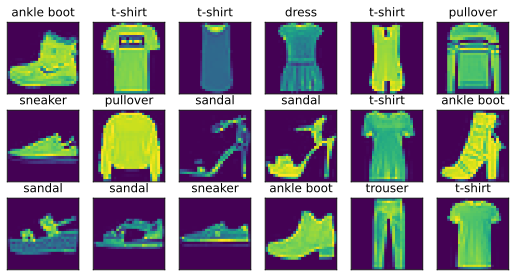

In [6]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 3, 6, titles=get_labels(y))


In [7]:
batch_size = 256
num_workers = 12
train_iter = data.DataLoader(mnist_train, batch_size, True, num_workers=num_workers)

In [8]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'0.55 sec'

## 以下才是关键代码

In [9]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../../data", train=False, transform=trans, download=True)
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers))

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(32, 64)
for X, y in train_iter:
    print(X.shape, y.shape, X.dtype, y.dtype)
    break

torch.Size([32, 1, 32, 32]) torch.Size([32]) torch.float32 torch.int64


In [ ]:
input_num = 28 * 28
output_num = 10
w = torch.normal(0, 0.01, (input_num, output_num), requires_grad=True)
b = torch.zeros(output_num, requires_grad=True)

In [15]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition
softmax(torch.tensor([[1, 2, 3], [4, 5, 6]]))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [51]:
def softmax_net(X, w, b):
    return softmax(torch.matmul(X.reshape((-1, w.shape[0])), w) + b)

In [ ]:
y = torch.tensor([2, 1])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

def cross_entropy(y, y_hat):
    return -torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y, y_hat)

tensor([0.5108, 1.6094])

In [ ]:
# ??? 引用还是值
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
def test(x):
    x[0][1] = 1
    print(x)
test(y_hat)
y_hat

tensor([[0.1000, 1.0000, 0.6000],
        [0.3000, 0.2000, 0.5000]])


tensor([[0.1000, 1.0000, 0.6000],
        [0.3000, 0.2000, 0.5000]])

In [59]:
def accuracy(y_hat, y): #数量
    if (len(y_hat.shape) > 1) & (y_hat.shape[1] > 1):   # 用and。。。
        y_hat = torch.argmax(y_hat, axis = 1)
    return float((y_hat==y).sum())
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.tensor([2, 2])
accuracy(y_hat, y)

2.0

In [48]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]        

In [54]:
def evaluate(net, data_iter):
    metric = Accumulator(2)
    if isinstance(net, torch.nn.Module):
        net.eval()
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X, w, b), y), len(y))  #y.numel()?
    return metric[0] / metric[1]

In [57]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param[:] -= param.grad * lr / batch_size
            param.grad.zero_()    #


##  训练

In [76]:
input_num = 28 * 28
output_num = 10
w = torch.normal(0, 0.01, (input_num, output_num), requires_grad=True)
b = torch.zeros(output_num, requires_grad=True)
train_iter, test_iter = load_data_fashion_mnist(256)

In [78]:

batch_size = 256
epochs = 16
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()
  metric = Accumulator(3)
  for X, y in train_iter:
    y_hat = net(X, w, b)
    l = loss(y, y_hat)
    l.sum().backward()
    sgd([w, b], lr=0.1, batch_size=batch_size)
    metric.add(l.sum(), accuracy(y_hat, y), y.numel())
  return metric[0]/metric[2], metric[1]/metric[2]

In [ ]:

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [71]:
import torch
from IPython import display
from d2l import torch as d2l

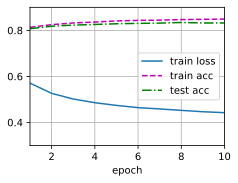

In [79]:
num_epochs = 10
train_ch3(softmax_net, train_iter, test_iter, cross_entropy, num_epochs, sgd)

In [105]:
train_iter, test_iter = load_data_fashion_mnist(8)

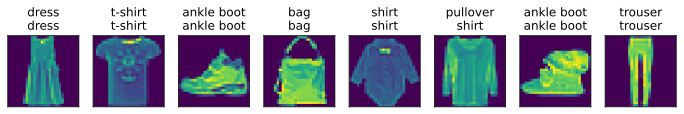

In [116]:
def predict_ch3(net, test_iter, n=8):
    for X, y in train_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(torch.argmax(net(X, w, b), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
predict_ch3(softmax_net, test_iter)